In [1]:
# %load_ext memory_profiler

# Capstone V4 model

Forked from V3.

This is a 4 GRU model - with a smaller vocab and q length than V3. The input to each GRU comes from one of the following 4 pre-trained embedding layers:
- glove.840B.300d
- paragram_300_sl999
- wiki-news-300d-1M
- GoogleNews-vectors-negative300

The validation F1-score is 0.321 at a threshold of 0.1.

TODO: rerun + debug as sharp drop is unexpected.

# Constants

In [2]:
MODEL_VERSION = 'capstoneV4'
MAX_SEQUENCE_LENGTH = 70
EMBEDDING_DIM = 300
MAX_WORDS = 40000

## Common english contraction mappings (wikipedia):
https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

In [3]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [4]:
PUNCT = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [5]:
SPECIAL_PUNCT = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}

In [6]:
PUNCT_MAPPING = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [7]:
MISPELL_MAPPING = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

# Helpers

## Embedding helpers

In [8]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import os

def loadEmbeddings(path, dimensions, mode='r', encoding=None, errors=None):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    f = open(path, buffering=((2<<16) + 8), mode=mode, encoding=encoding, errors=errors)
    for line in f:
        if len(line) <= 100:
            continue
        values = line.split()
        word = ''.join(values[:-dimensions])
        coefs = np.asarray(values[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [9]:
def loadEmbeddingsGensim(path, dimensions, binary=True):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    gensim_vecs = KeyedVectors.load_word2vec_format(path, binary=binary)
    for word, vector in zip(gensim_vecs.vocab, gensim_vecs.vectors):
        coefs = np.asarray(vector[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [10]:
def getEmbeddingMatrix(embedding, word_index):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    nb_words = min(MAX_WORDS, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

### Helper to replace contractions in dataset

In [11]:
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([CONTRACTION_MAPPING[t] if t in CONTRACTION_MAPPING else t for t in text.split(" ")])
    return text

### Helper to remap punctuations in dataset

In [12]:
def clean_special_chars(text):
    for p in PUNCT_MAPPING:
        text = text.replace(p, PUNCT_MAPPING[p])
    
    for p in PUNCT:
        text = text.replace(p, ' ' + p + ' ')
    
    for s in SPECIAL_PUNCT:
        text = text.replace(s, SPECIAL_PUNCT[s])
    
    return text

### Helper to correct common mispellings

In [13]:
def correct_spelling(x):
    for word in MISPELL_MAPPING.keys():
        x = x.replace(word, MISPELL_MAPPING[word])
    return x

## Coverage helpers

In [14]:
from collections import Counter

def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = Counter()
    for sentence in sentences:
        for word in sentence:
            vocab[word] += 1
    return vocab

In [15]:
import operator

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

# Import test/train dataset

In [196]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1

# Analyze train and test data

In [17]:
print("Sample insincere questions")
train_df.loc[train_df['target'] == 1].sample(10)

Sample insincere questions


,qid,question_text,target
198036,26b65dcdd60d105daef5,Christians: Should atheists be allowed to vote in the United States?,1
882293,acd9d5ba80f463c47cae,Why do people on Quora simplify the complexity of the world in their questions?,1
133331,1a19325fda11dbab9c8f,"What would happen if Erdogan, the President of Turkey, declared a jihad on Greece like he recently threatened to? Does he even have the rights to do that under Sharia law? Would other Muslim extremist groups support him?",1
733415,8fa4e845df9214d52be2,"Why does Modi have a low IQ, even lower than the Indians PISA kids who scored bottom of the world?",1
1304137,ff9cbe21b9a127b9ef09,Why do Indians on Quora indulge so much in spreading lies and negativity about Pakistan?,1
786611,9a1a5d3891265a25be7c,Should President Trump receive the Nobel Peace Prize for inducing North Korea to officially end the war with South Korea and ending its nuclear bomb program?,1
908508,b204cf237a0132a7b83a,Why are Muslims from Egypt far more religion conscious and god fearing as compared to Turkey?,1
1149877,e14c8ee3cd0dbacd772c,Is there any hard evidence of Japan's guilt in the attack on Pearl Harbor?,1
1125908,dca2df02ce65268629b4,"Why are SJWs trying so very hard to make the New Order from star wars, look like angry trump and white surpremacits, when classically the Galactic Empire employed aliens in their ranks? Why the push to make whites racist?",1
930430,b6572ce4aa9f74c5acf3,"Do you find it sad that Trump has a more realistic and rational environmental policy than all the liberals, including Barack Obama?",1


In [18]:
print("Sample sincere questions")
train_df.loc[train_df['target'] == 0].sample(10)

Sample sincere questions


,qid,question_text,target
488608,5fb17bba599e89e082a4,Why do babies cry at birth?,0
691418,876a327a8fa92c293baa,Am I wrong for not forgiving my family for ruining my childhood?,0
602177,75f139144598e0324bb5,Is there anyone who provide home fitness services in Karachi?,0
120233,178a1773840bea70ecc2,Do you need a specific prescription for computer glasses?,0
310437,3ccf7886d15f325ace81,When did shaving your head due to balding become common place?,0
864719,a96d90f013ff09f07753,Do intelligent people tend to criticize more and demand total perfection?,0
331004,40e0410129d7fa035d2f,How can I set limited quantity for Configurable Product in Magento?,0
958232,bbb9f940c1a03110cdfc,What was the grand tour of the HMS Challenger?,0
1024619,c8c99adb143ffcc14277,What cost saving have you done at your abode being a mechanical engineer?,0
323560,3f6b781e32e294ab5b80,What impact investing funds publicly share their portfolios and selection criteria?,0


In [19]:
import matplotlib.pyplot as plt
import numpy as np

target_ratios = train_df.target.value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios (target)')
plt.show()

0    0.93813
1    0.06187
Name: target, dtype: float64


<Figure size 640x480 with 1 Axes>

In [20]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [21]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [22]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 70.


In [23]:
print('Max character length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x)))))
print('Max character length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x)))))

Max character length of questions in train is 1017.
Max character length of questions in test is 588.


In [24]:
print('p999 character length of questions in train is {0:.0f}.'.format(np.percentile(train_df['question_text'].apply(lambda x: len(x)), 99.9)))
print('p999 character length of questions in test is {0:.0f}.'.format(np.percentile(test_df['question_text'].apply(lambda x: len(x)), 99.9)))

p999 character length of questions in train is 249.
p999 character length of questions in test is 249.


# Data processing


## TODO: Feature engineering

Add feature engineering here.

In [25]:
%%time

train_df['treated_question'] = train_df['question_text'].apply(lambda x: x.lower())
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_contractions(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_special_chars(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: correct_spelling(x))

test_df['treated_question'] = test_df['question_text'].apply(lambda x: x.lower())
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_contractions(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_special_chars(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: correct_spelling(x))

CPU times: user 50.7 s, sys: 316 ms, total: 51 s
Wall time: 51 s


## Fill data

In [26]:
X_train = train_df['treated_question'].fillna('+++').tolist()
y_train = train_df['target']
X_test = test_df['treated_question'].fillna('+++').tolist()


print('Found %s training questions.' % len(X_train))
print('Found %s test questions.' % len(X_test))

Found 1306122 training questions.
Found 56370 test questions.


In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, split=' ', filters='',
                       char_level=False, oov_token=None, document_count=0,
                      )
                                   
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Shape of X_train: (1306122, 70)
Shape of y_train: (1306122,)
Found 195975 unique tokens.


## Save tokenized data + word index

In [28]:
%%time

import gc
import pickle

test_df.to_pickle('test_df.pkl')

np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
y_train.to_pickle('y_train.pkl')

pickle.dump(word_index, open('word_index.pkl', 'wb'))

del X_train
del X_test
del y_train

gc.collect()


CPU times: user 224 ms, sys: 376 ms, total: 600 ms
Wall time: 1.01 s


## Build vocabulary with counts

In [29]:
%%time

train_vocab = build_vocab(train_df['treated_question'])
del train_df
test_vocab = build_vocab(test_df['treated_question'])
del test_df

vocab = train_vocab + test_vocab
del train_vocab
del test_vocab

CPU times: user 13.6 s, sys: 468 ms, total: 14.1 s
Wall time: 14.1 s


## Load embeddings, measure coverage and save embedding matrix

# Restore point (optional)

In [84]:

import pickle

word_index = pickle.load(open('word_index.pkl', 'rb'))


In [31]:
%%time

import gc

print('glove:')
glove_path = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
embeddings_index = loadEmbeddings(glove_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('glove.npy', embedding_matrix)

glove:
Loading embeddings from: ../input/embeddings/glove.840B.300d/glove.840B.300d.txt
Found 2195892 word vectors.
Found embeddings for 63.10% of vocab
Found embeddings for  99.39% of all text
CPU times: user 2min 43s, sys: 6.88 s, total: 2min 50s
Wall time: 2min 50s


In [32]:
print('paragram:')
paragram_path = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
embeddings_index = loadEmbeddings(paragram_path, EMBEDDING_DIM, encoding='utf8', errors='ignore')
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('paragram.npy', embedding_matrix)

paragram:
Loading embeddings from: ../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt
Found 1703663 word vectors.
Found embeddings for 74.06% of vocab
Found embeddings for  99.64% of all text


In [33]:
print('wiki:')
wiki_path = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
embeddings_index = loadEmbeddings(wiki_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('wiki.npy', embedding_matrix)

wiki:
Loading embeddings from: ../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec
Found 999994 word vectors.
Found embeddings for 48.05% of vocab
Found embeddings for  98.81% of all text


In [34]:
print('google_news:')
google_news_path = '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
embeddings_index = loadEmbeddingsGensim(google_news_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('google_news.npy', embedding_matrix)

google_news:
Loading embeddings from: ../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin
Found 3000000 word vectors.
Found embeddings for 38.68% of vocab
Found embeddings for  78.84% of all text


In [35]:
del word_index
del vocab
gc.collect()

0

# Oversample training data

In [36]:
'''
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
'''


'\nfrom imblearn.over_sampling import SMOTE\n\nsm = SMOTE(random_state=42, ratio = 1.0)\nX_train, y_train = sm.fit_sample(X_train, y_train)\n'

In [37]:
'''
balanced_train_df = pd.DataFrame()
balanced_train_df[0] = np.array(y_train)

target_ratios = balanced_train_df[0].value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios after SMOTE (target)')
'''

"\nbalanced_train_df = pd.DataFrame()\nbalanced_train_df[0] = np.array(y_train)\n\ntarget_ratios = balanced_train_df[0].value_counts(normalize=True)\n\nprint(target_ratios)\n\ntarget_ratios.plot(kind='bar', title='Ratios after SMOTE (target)')\n"

# Setup model

# Restore point

In [38]:
%%time

import numpy as np
import pandas as pd
import pickle

test_df = pd.read_pickle('test_df.pkl')

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = pd.read_pickle('y_train.pkl')


CPU times: user 68 ms, sys: 208 ms, total: 276 ms
Wall time: 1.56 s


## Embeddings Layers

In [39]:
from keras.layers import Embedding

embedding_layers = {}

embedding_matrix = np.load('glove.npy')
embedding_layers['glove'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

embedding_matrix = np.load('paragram.npy')
embedding_layers['paragram'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

embedding_matrix = np.load('wiki.npy')
embedding_layers['wiki'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

embedding_matrix = np.load('google_news.npy')
embedding_layers['google_news'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

## NN: Bidirectional GRU per embedding with concactenation

In [40]:
%%time 

from keras.layers import Dense, Dropout, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional
from keras.layers import Activation, BatchNormalization, CuDNNGRU
from keras.layers import SpatialDropout1D, Concatenate, Flatten, Reshape
from keras.regularizers import l2
from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

a = embedding_layers['glove'] (inp)
a = Bidirectional(CuDNNGRU(64, return_sequences=True))(a)
a = BatchNormalization()(a)
a = GlobalMaxPool1D()(a)
a = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(a)
a = BatchNormalization()(a)
a = Activation("relu")(a)
a = Dropout(0.2)(a)

b = embedding_layers['paragram'] (inp)
b = Bidirectional(CuDNNGRU(64, return_sequences=True))(b)
b = BatchNormalization()(b)
b = GlobalMaxPool1D()(b)
b = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(b)
b = BatchNormalization()(b)
b = Activation("relu")(b)
b = Dropout(0.2)(b)

c = embedding_layers['wiki'] (inp)
c = Bidirectional(CuDNNGRU(64, return_sequences=True))(c)
c = BatchNormalization()(c)
c = GlobalMaxPool1D()(c)
c = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Dropout(0.2)(c)

d = embedding_layers['google_news'] (inp)
d = Bidirectional(CuDNNGRU(64, return_sequences=True))(d)
d = BatchNormalization()(d)
d = GlobalMaxPool1D()(d)
d = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(d)
d = BatchNormalization()(d)
d = Activation("relu")(d)
d = Dropout(0.2)(d)

x = Concatenate(axis=1)([a, b, c, d])
x = Dense(32, kernel_regularizer=l2(0.01), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, use_bias=False)(x)
x = BatchNormalization()(x)
out = Activation("sigmoid")(x)

model = Model(inp, out)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 300)      12000000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 70, 300)      12000000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 70, 300)      12000000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [41]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

# Compile the model

In [42]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', f1, recall, precision])

# serialize model

In [43]:
model.save('model.h5')
print("Saved model to disk")

Saved model to disk


# Setup f1-score, precision and recall metrics

In [44]:
'''
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

class Metrics(Callback):


    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average='binary')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()
'''

'\nfrom keras.callbacks import Callback\nfrom sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support\n\nclass Metrics(Callback):\n\n\n    def on_train_begin(self, logs={}):\n        self.val_f1s = []\n        self.val_recalls = []\n        self.val_precisions = []\n \n\n    def on_epoch_end(self, epoch, logs={}):\n        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()\n        val_targ = self.validation_data[1]\n        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average=\'binary\')\n        self.val_f1s.append(_val_f1)\n        self.val_recalls.append(_val_recall)\n        self.val_precisions.append(_val_precision)\n        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))\n        return\n\nmetrics = Metrics()\n'

# Compute Class Weights

Since there is a significant target inbalance.

In [45]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

print (class_weights)

[0.53297527 8.08143794]


## Split train/validation

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8,
                                              random_state=233, shuffle=True)

/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [47]:
from keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(monitor='val_f1',
                      min_delta=0,
                      patience=12,
                      verbose=1, mode='max',
                      restore_best_weights=True
                )

# Train the model

Use model checkpointing to save the model that attains the best validation loss.

In [ ]:
%%time

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[earlyStopping], class_weight=class_weights, epochs=20, batch_size=256)


Train on 1044897 samples, validate on 261225 samples
Epoch 1/20
1044897/1044897 [==============================] - 268s 256us/step - loss: 0.3055 - acc: 0.9407 - f1: 0.5867 - recall: 0.6426 - precision: 0.5880 - val_loss: 0.2455 - val_acc: 0.9267 - val_f1: 0.5861 - val_recall: 0.8581 - val_precision: 0.4510
Epoch 2/20
1044897/1044897 [==============================] - 261s 250us/step - loss: 0.1223 - acc: 0.9569 - f1: 0.5955 - recall: 0.5285 - precision: 0.7096 - val_loss: 0.1349 - val_acc: 0.9567 - val_f1: 0.6607 - val_recall: 0.7045 - val_precision: 0.6345
Epoch 3/20
1044736/1044897 [============================>.] - ETA: 0s - loss: 0.1076 - acc: 0.9588 - f1: 0.6179 - recall: 0.5557 - precision: 0.7242

# Predict validation labels

In [51]:
%%time

pred_val = model.predict([X_val], batch_size=1024, verbose=1)

261225/261225 [==============================] - 9s 36us/step
CPU times: user 9 s, sys: 1.77 s, total: 10.8 s
Wall time: 9.35 s


# Find optimal threshold

In [53]:
from sklearn.metrics import f1_score, precision_score, recall_score

def optimalThreshold(y_true,y_pred):
    idx = 0
    cur_f1 = 0
    cur_prec = 0
    cur_recall = 0
    max_f1 = 0
    thres = 0
    for idx in np.arange(0.1, 0.501, 0.01):
        cur_f1 = f1_score(y_true, np.array(y_pred)> idx)
        cur_recall = recall_score(y_true, np.array(y_pred)> idx)
        cur_prec = precision_score(y_true, np.array(y_pred)> idx)
        print('Current threshold is {:.4f} with F1 score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}'
              .format(idx, cur_f1, cur_recall, cur_prec)
             )
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            thres = idx
    print('optimal threshold is {:.4f} with F1 score: {:.4f}'.format(thres, max_f1))
    return thres
threshold = optimalThreshold(y_val,pred_val)

Current threshold is 0.1000 with F1 score: 0.3987, Recall score: 0.9601, Precision score: 0.2516
Current threshold is 0.1100 with F1 score: 0.4163, Recall score: 0.9545, Precision score: 0.2662
Current threshold is 0.1200 with F1 score: 0.4333, Recall score: 0.9506, Precision score: 0.2806
Current threshold is 0.1300 with F1 score: 0.4493, Recall score: 0.9459, Precision score: 0.2946
Current threshold is 0.1400 with F1 score: 0.4644, Recall score: 0.9410, Precision score: 0.3082
Current threshold is 0.1500 with F1 score: 0.4789, Recall score: 0.9355, Precision score: 0.3218
Current threshold is 0.1600 with F1 score: 0.4940, Recall score: 0.9307, Precision score: 0.3362
Current threshold is 0.1700 with F1 score: 0.5075, Recall score: 0.9255, Precision score: 0.3496
Current threshold is 0.1800 with F1 score: 0.5202, Recall score: 0.9203, Precision score: 0.3626
Current threshold is 0.1900 with F1 score: 0.5319, Recall score: 0.9149, Precision score: 0.3749
Current threshold is 0.2000 wi

In [55]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, np.array(pred_val > threshold).astype(int), target_names=['sincere', 'insincere']))


             precision    recall  f1-score   support

    sincere       0.98      0.97      0.98    245044
  insincere       0.64      0.71      0.67     16181

avg / total       0.96      0.96      0.96    261225



[Text(0, 0.5, 'sincere'), Text(0, 1.5, 'insincere')]

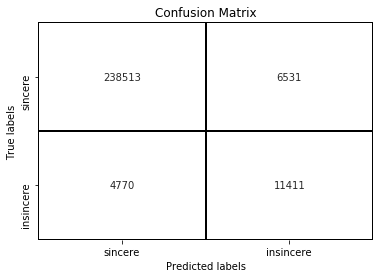

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = confusion_matrix(y_val, np.array(pred_val > threshold).astype(int))
ax = plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', 
                 cmap=ListedColormap(['white']), linecolor='black', 
                 linewidth=1, cbar=False,
                 xticklabels = 1, yticklabels = 1 )


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['sincere', 'insincere'])
ax.yaxis.set_ticklabels(['sincere', 'insincere'])



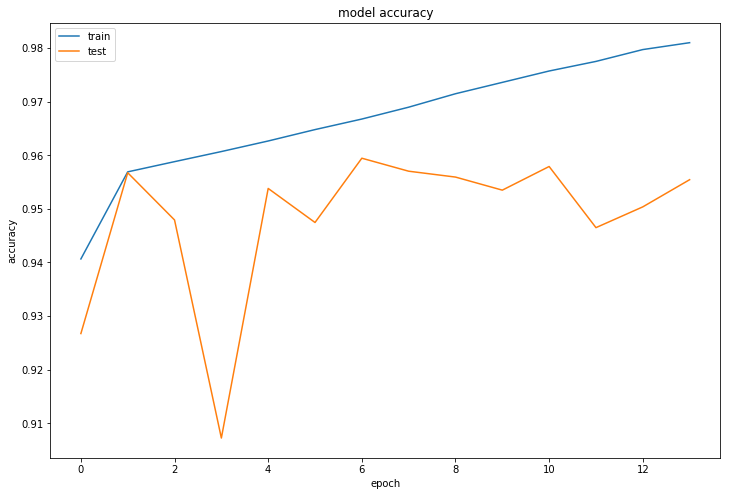

In [59]:
plt.figure(figsize=(12,8))
plt.title('model accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

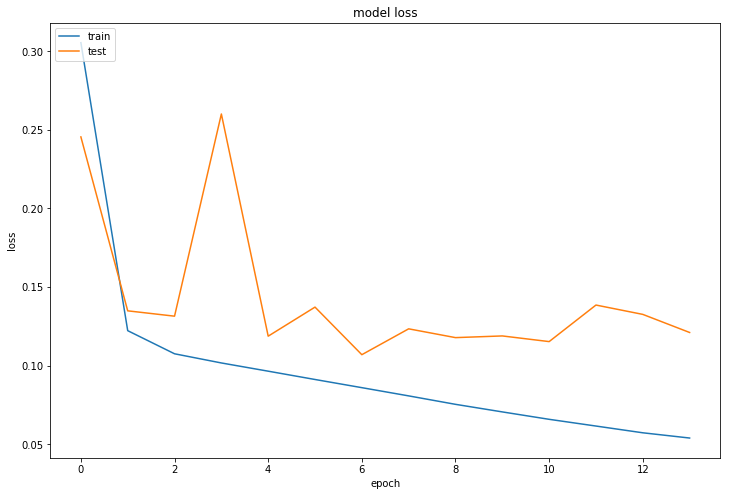

In [61]:
plt.figure(figsize=(12,8))
plt.title('model loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

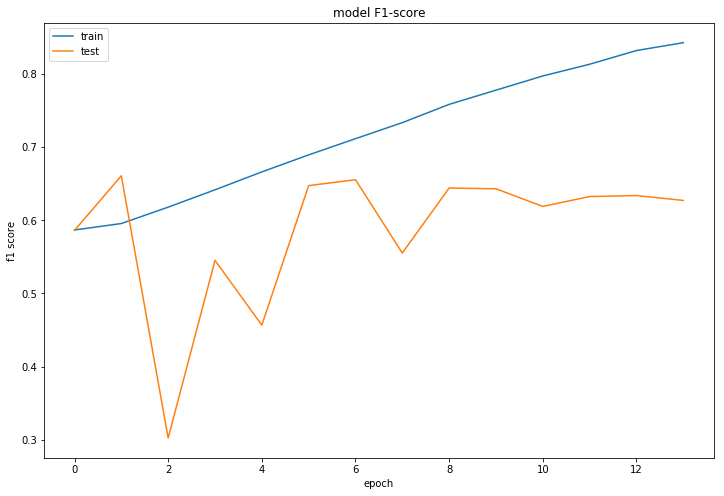

In [63]:
plt.figure(figsize=(12,8))
plt.title('model F1-score')
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize weights

In [65]:
model.save_weights(MODEL_VERSION + '.weights.h5')
print("Saved model weights to disk")

Saved model weights to disk


# Predict test labels

In [67]:
%%time

pred_test = model.predict([X_test], batch_size=1024, verbose=1)

56370/56370 [==============================] - 2s 36us/step
CPU times: user 2.02 s, sys: 284 ms, total: 2.3 s
Wall time: 2.02 s


# Prepare submission

In [69]:
submission_df = pd.DataFrame({"qid":test_df["qid"].values})
submission_df['prediction'] = (pred_test > threshold).astype(int)
submission_df.to_csv("submission.csv", index=False)

# Validation analysis

In [85]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [74]:
print(threshold)

0.4999999999999998


In [234]:
prediction_df = pd.DataFrame({"target": y_val})
prediction_df['prediction'] = (pred_val > threshold).astype(int)
prediction_df['pred_val'] =  pred_val
prediction_df['question_text_rebuilt'] =  pd.Series(X_val.tolist()).map(lambda seqs: [reverse_word_map[seq] for seq in seqs if seq > 0]).str.join(" ")

In [235]:
prediction_df[prediction_df["prediction"] != prediction_df["target"]].sample(10)

,target,prediction,pred_val,question_text_rebuilt
185741,1,0,0.331036,how different would metrics regarding us quality of life be if hispanic and african americans were excluded from the calculations ?
90486,0,1,0.578600,"will hindus ever have a country of their own official "" hindu "" country ?"
143618,0,1,0.674987,are there a lot of closeted gays in the bronx ?
59502,1,0,0.047500,what is the function of charcoal mask blackhead remover mask ?
201966,1,0,0.246436,was the supposed prophet muhammad the first harvey weinstein in history ?
85411,0,1,0.804730,what is the difference between a slut & a bitch ?
85246,0,1,0.811691,can two black people have a white baby ?
111308,1,0,0.012530,what products can make the most money for agents now ?
235103,0,1,0.729320,how do muslims feel about knowing that the ones that defend them in the western world are the that most differs from them ideologically ?
101297,1,0,0.277380,should amy pascal and avi drop dead for ruining spider - man so badly ?


In [236]:
misclassified_df = prediction_df[prediction_df["prediction"] != prediction_df["target"]]

In [237]:
misclassified_df[misclassified_df["pred_val"] == misclassified_df["pred_val"].min()]

,target,prediction,pred_val,question_text_rebuilt
56946,1,0,0.0102,what are the most profitable businesses for villages ?


In [238]:
misclassified_df[misclassified_df["pred_val"] == misclassified_df["pred_val"].max()]

,target,prediction,pred_val,question_text_rebuilt
227861,0,1,0.98188,"did eunuchs "" become "" gay by being castrated ?"


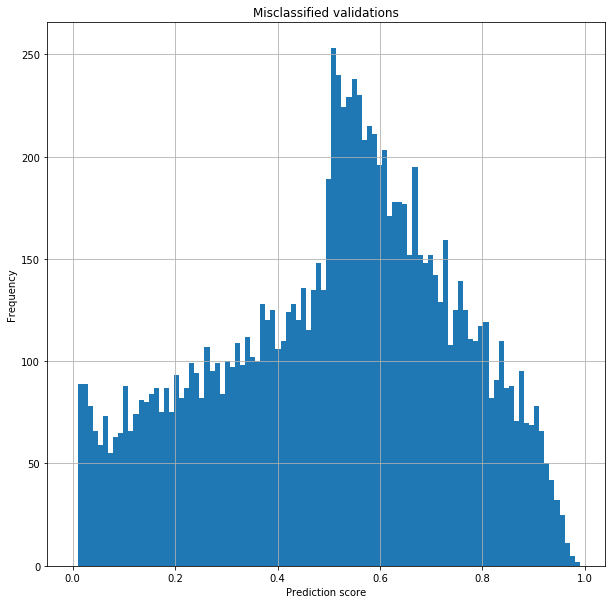

In [240]:
ax = misclassified_df["pred_val"].hist(figsize=(10, 10), bins=100, range=(0, 0.99))
ax.set_title('Misclassified validations')
ax.set_xlabel('Prediction score')
ax.set_ylabel('Frequency')
plt.show()

In [241]:
misclassifed_mean = misclassified_df["pred_val"].mean()
print(misclassifed_mean)

0.5091663


In [242]:
misclassifed_std = misclassified_df["pred_val"].std()
print(misclassifed_std)

0.23220365


In [254]:
false_positive = misclassified_df[misclassified_df["prediction"] == 1]
false_positive_extreme = false_positive[false_positive["pred_val"] >= misclassifed_mean + misclassifed_std]

false_negative = misclassified_df[misclassified_df["prediction"] == 0]
false_negative_extreme = false_negative[false_negative["pred_val"] <= misclassifed_mean - misclassifed_std]

In [257]:
false_positive_extreme.sample(10)

,target,prediction,pred_val,question_text_rebuilt
41469,0,1,0.927667,"why do some liberals ignore israelites ' sufferings and struggles for a free , democratic and independent israel ? how can they support those cruel islamists ?"
224583,0,1,0.741720,do koreans use water to clean their bottom ? do they have bidet in toilet as muslim countries do or clean with toilet paper only ?
189608,0,1,0.750678,"are the evangelicals in the usa racist , fascist or what ? and what is their relationship with gun lobby group ?"
23054,0,1,0.974254,"in this enlightened nation people believe sex offenders should be castrated , do you ? how about other criminals , should they be mutilated ad well ?"
103058,0,1,0.782203,"how the hell do most asian women get those big , strong , and beautiful muscular legs without exercising ?"
130397,0,1,0.758577,did prophet muhammad made any woman swallow his semen ?
244774,0,1,0.773128,why do half of americans believe trump colluded with russia and half believe he was framed by the department of justice ?
149802,0,1,0.934981,why do black people in general face more racism than white people based on skin color ?
234506,0,1,0.767865,why should young south africans stay in the country ? considering the countries recent junk status .
102520,0,1,0.808862,"why do not chinese officials suffer from incompetence despite the fact that china has a "" repressive "" system ?"


In [258]:
false_negative_extreme.sample(10)

,target,prediction,pred_val,question_text_rebuilt
258563,1,0,0.142188,do you listen to the lies of god ?
93293,1,0,0.056738,what are some good things done by isis ?
177430,1,0,0.233607,"i live like i am homeless , yet i have 2 million dollars sitting in the bank and a condo paid for . i basically just wander around all day doing nothing . is not life great ?"
184247,1,0,0.237611,how does being in the same building that someone died in make your gun intelligence immediately ?
226969,1,0,0.050864,is it possible to sue my parents for me ?
69961,1,0,0.142670,why do people try to save suicidal persons they dont even know ?
26676,1,0,0.094318,why is my urine yellow instead of the usual opaque red ?
183571,1,0,0.015124,who wants the best dissertation writing service in usa ?
126414,1,0,0.140942,what does your butt look like ?
127575,1,0,0.041702,can you get a speeding ticket for traveling faster than the speed of light ? what cop is going to catch you ?


In [265]:
false_positive[~false_positive.isin(false_positive_extreme).all(1)].sample(10)

,target,prediction,pred_val,question_text_rebuilt
142346,0,1,0.668906,why does youtube allow hungarian dictatorship ' s fascist propaganda to be streamed as advert between every three or so videos ? is that legal ?
50541,0,1,0.683686,it has been brought to my notice that a lot of misinformation is being spread by the media in india . should there be a regulatory body to curb the reach of misinformation ? can such a body function while keeping the process democratic ?
233793,0,1,0.640572,"how much do you agree with the statement of an atheist that missionaries , not aid money , are the solution to africa ' s biggest problem - the crushing of the people ' s mindset ?"
73156,0,1,0.535842,what are current frauds that most indians are unaware of ?
194563,0,1,0.644689,is energy of indian youth being wasted in communal discussions around several fake news coming out of bjp it cells ?
83273,0,1,0.702371,what should my 18 years old friend should when her real father is sexually exploiting her and indirectly indicating her for sex . her own mother is not supporting her and ignoring daily exploitation ?
29493,0,1,0.716945,why does hillary clinton blame sexism and everything else except her own track record in politics for her constant presidential election loss ?
234885,0,1,0.608558,how can we rally together to encourage state to have an article 5 constitutional amendment to help undue 12 liberal damage ?
91744,0,1,0.582117,are indian malaysians in the current generation losing in touch with their culture ?
115419,0,1,0.516103,if eventually we will all die and our planet will be swallowed by the sun why do we allow petty differences to divide us ?


In [266]:
false_negative[~false_negative.isin(false_negative_extreme).all(1)].sample(10)

,target,prediction,pred_val,question_text_rebuilt
89924,1,0,0.490206,what 3 things does the flat earth debate and the official holocaust narrative have in common ?
219780,1,0,0.409271,"if one can plea ' temporary insanity ' & escape prosecution for crimes , can the law ' legally ' prosecute anyone who declared himself as a christian ?"
257146,1,0,0.456394,why would a girl search on google for vaginas and not for penises ?
209300,1,0,0.350013,why is not hindi the national language of france ?
91121,1,0,0.455431,how did the jews recognize each other as jews ?
137122,1,0,0.431677,should british teach americans the sport of cricket ?
78053,1,0,0.301567,is a virgina a penis ?
32906,1,0,0.452100,"i am a christian , but my best friend is gay . i do not like the idea of him burning in the deepest depths of hell for eternity . what can be done ?"
17718,1,0,0.434658,is the doj ' s attempt to block information from congressman nunes evidence that the secret society exists ?
104064,1,0,0.363152,is criminology a topic worthy of study or just a mix of psychological outdated theories built into a course for employing lowly teachers in expensive and useless degrees ?
